In [13]:
import random
import string
import xarray as xr
import pandas as pd
import numpy as np
from ntv_numpy import Xdataset
import ntv_pandas as npd
import cbor2
import matplotlib.pyplot as plt

In [9]:
def file_sizes(xnd):
    '''calculate the size of each format'''
    df = xnd.to_dataframe(json_name=False, info=False).reset_index().sample(frac=1)
    return {'pd.to_json(values)': len(df.to_json(orient='values')),
            'pd.to_csv': len(df.to_csv()),
            'pd.to_parquet': len(df.to_parquet(engine='pyarrow')),
            'nxr.to_json': len(xnd.to_json(notype='all', header=False, encoded=True)),
            'nxr.to_json(cbor)': len(cbor2.dumps(xnd.to_json(notype='all', header=False, encoded=False)))}

def sizes_plot(sizes, titles, fig_title):
    '''plot the size of some format''' 
    fig, axs = plt.subplots(1, 4, figsize=(24, 6))
    fig.suptitle(fig_title)
    for idx, (size, title) in enumerate(zip(sizes, titles)):
        bar_colors = ['tab:red' if val == min(size.values()) else 'tab:blue' for val in size.values()]
        percent = [str(round(val / list(size.values())[1] * 100, 1)) + ' %' for val in size.values()]
        bar_plt = axs[idx].bar(size.keys(), size.values(), color=bar_colors)
        axs[idx].set_title(title)
        axs[idx].bar_label(bar_plt, percent, label_type='center')
        axs[idx].tick_params(axis='x', rotation=55)
    plt.show()

# multidimensional

In [25]:

def coords_int(val, leng):
    return np.arange(val, val+leng)

def coords_str(leng):
    return np.array([''.join(random.choices(string.ascii_letters, k=12)) for _ in range(leng)])
    
fields = ['a', 'b', 'c', 'd', 'e']
nb1 = 4
nb2 = 10
xdss = [xr.Dataset({"var": (fields, np.arange(nb1**5).reshape(nb1, nb1, nb1, nb1, nb1))}, coords={field: coords_int(val*nb1, nb1) for val, field in enumerate(fields)}),
        xr.Dataset({"var": (fields, np.arange(nb1**5).reshape(nb1, nb1, nb1, nb1, nb1))}, coords={field: coords_str(nb1) for val, field in enumerate(fields)}),
        xr.Dataset({"var": (fields, np.arange(nb2**5).reshape(nb2, nb2, nb2, nb2, nb2))}, coords={field: coords_int(val*nb2, nb2) for val, field in enumerate(fields)}),
        xr.Dataset({"var": (fields, np.arange(nb2**5).reshape(nb2, nb2, nb2, nb2, nb2))}, coords={field: coords_str(nb2) for val, field in enumerate(fields)})] #,

Xdataset.from_xarray(xdss[0]).to_dataframe(ntv_type=False, info=False).reset_index()

,a,b,c,d,e,var
0,0,4,8,12,16,0
1,0,4,8,12,17,1
2,0,4,8,12,18,2
3,0,4,8,12,19,3
4,0,4,8,13,16,4
...,...,...,...,...,...,...
1019,3,7,11,14,19,1019
1020,3,7,11,15,16,1020
1021,3,7,11,15,17,1021
1022,3,7,11,15,18,1022


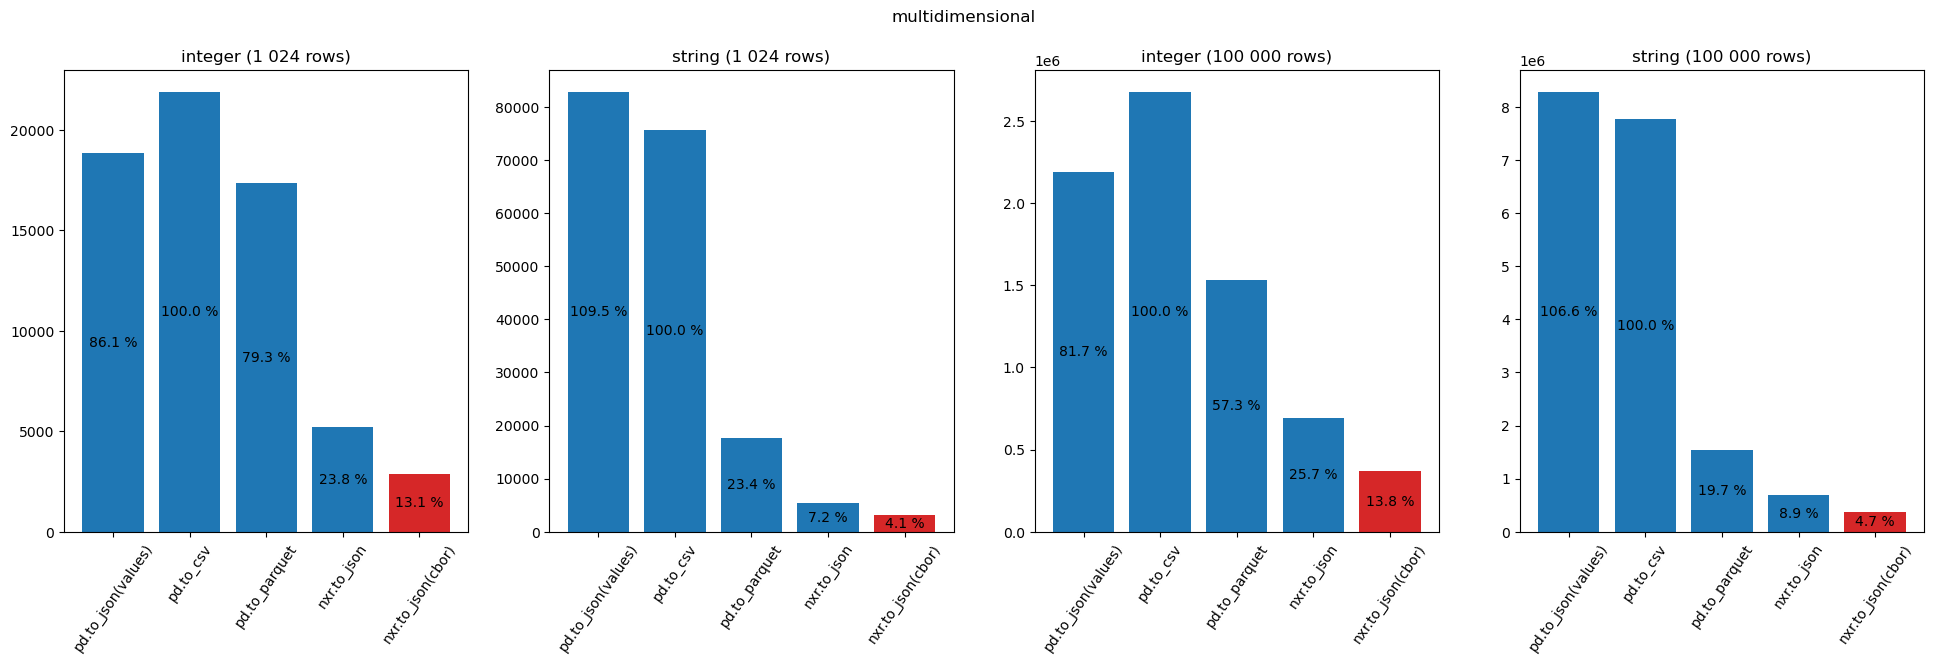

In [26]:
xnds = [Xdataset.from_xarray(xds) for xds in xdss]
sizes = [file_sizes(xnd) for xnd in xnds]
titles = ['integer (1 024 rows)', 'string (1 024 rows)', 'integer (100 000 rows)', 'string (100 000 rows)']
sizes_plot(sizes, titles, 'multidimensional')

# tree

In [28]:
# size = 15
size = 10
arr = np.arange(2**size)
data_int = [arr]
data_str = [np.frompyfunc(str, 1, 1)(arr)]
for i in range(size):
    arr = arr // 2
    data_int.append(arr)
    data_str.append(np.frompyfunc(str, 1, 1)(arr))
tab_int_tree = {'col_' + str(i): data_int[i] for i in range(len(data_int))}
tab_str_tree = {'col_' + str(i): data_str[i] for i in range(len(data_str))}

In [29]:
df_int_tree = pd.DataFrame(tab_int_tree)
df_str_tree = pd.DataFrame(tab_str_tree)
df_int_tree

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10
0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,2,1,0,0,0,0,0,0,0,0,0
3,3,1,0,0,0,0,0,0,0,0,0
4,4,2,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1019,1019,509,254,127,63,31,15,7,3,1,0
1020,1020,510,255,127,63,31,15,7,3,1,0
1021,1021,510,255,127,63,31,15,7,3,1,0
1022,1022,511,255,127,63,31,15,7,3,1,0


In [ ]:
df_int_tree = df_int_tree.sample(frac=1).reset_index(drop=True)
df_str_tree = df_str_tree.sample(frac=1).reset_index(drop=True)

In [ ]:
res_tree = []
for df in [df_int_tree, df_str_tree]:
    csv = df.to_csv()
    xnd = Xdataset.from_dataframe(df)
    jsn_full_txt = xnd.to_json(notype='all', encoded=True)
    jsn_full = xnd.to_json(notype='all')
    forma = {name:'complete' for name in xnd.names[1:]}
    jsn_comp_txt = xnd.to_json(notype='all', format=forma, encoded=True)
    jsn_comp = xnd.to_json(notype='all', format=forma)
    jsb_comp = cbor2.dumps(jsn_comp)
    
    res_tree.append([len(jsb_comp)/1024, len(jsn_comp_txt)/1024, len(jsn_full_txt)/1024, len(csv)/1024])
res_tree

In [ ]:
from time import time

df = df_int_tree
tim = [] 
tim.append(time())
csv = df.to_csv()
tim.append(time())
xnd = Xdataset.from_dataframe(df, distr=False)
tim.append(time())
jsn_full_txt = xnd.to_json(notype='all', encoded=True)
tim.append(time())
jsn_full = xnd.to_json(notype='all')
tim.append(time())
forma = {name:'complete' for name in xnd.names[1:]}
tim.append(time())
jsn_comp_txt = xnd.to_json(notype='all', format=forma, encoded=True)
tim.append(time())
jsn_comp = xnd.to_json(notype='all', format=forma)
tim.append(time())
jsb_comp = cbor2.dumps(jsn_comp)
tim.append(time())

dt = [tim[i+1] - tim[i] for i in range(len(tim)-1)]
dt
    

In [ ]:
from xconnector import PandasConnec
t0=time()
PandasConnec._ximport_analysis(df_int_tree, None, distr=True)
print(time()-t0)